# Richardson Lucy Algorithm
Even knowing convolution kernel isn't enough to de-blur an image. This is because any noise present in the image is amplified during de-convolution and adds significant visual disturbances. 

## Theory
The matrices $f$, $f'$ and $k$ describe the proportion of light in: the true image, the observed image and the convolution kernel respectively, and are related by either $f'_i =\sum_j k_{i,j}f_j$ or $f' = f * k$. When the letters are unscripted (e.g. $f$) that means they are referring to the whole array. When they are scripted (e.g. $f_{i}$) then they are referring to the value in the $i$ th location. 

The Richardson Lucy algorithm is an iterative process which predicts predicts the true image accounting for noise:
$$\hat{f}_j^{t+1} = \hat{f}_j^{t}\sum_i \frac{f'^{t}_i}{\hat{f'}^{t}_i}k_{i,j} \text{  [1]}$$
- Where $\hat{f}_j^{t+1}$ is the $t+1$ th estimated value of $f_j$. 
- $\hat{f'}_i$ is the predicted light intensity in the observed image given as $\hat{f'}_i = \sum_j k_{i,j}\hat{f}_j$.   
- $\frac{f'^t_i}{\hat{f}^{t}_i}$ is the correcting factor. It determines the difference between the measured light intensity and the prediction of the light intensity from the previous estimate. 
- If $p_{i,j}$ is normalized ($\sum_j p_{i,j} = 1$) 
- The richardson lucy algorithm often converges as the process is self correcting [1].

Using convolution the algorithm can be written for the 2D case:
$$\hat{f}^{t+1} = \hat{f}^{t} \cdot \left(\frac{f'^t}{\hat{f'}^{t}}*k^* \right)$$
- Where $k^*$ is the mirrored convolution kernel.
- $\hat{f'}$ is the predicted light intensity in the observed image given as $\hat{f'}^{t} = \hat{f}^{t} * k$.
## Basic 1D implementation

## Python implementation

In [54]:
from torchvision import transforms
import torch
from PIL import Image
import matplotlib.pyplot as plt
from ImageDebluring import *

In [55]:
def richardson_lucy(degraded_img, kernel, num_iters, estimate = None, c = 1e-10):    
    if estimate is None:
        estimate = torch.ones_like(degraded_img)  # Initial estimate
    kernel_mirror = torch.flip(kernel, [0, 1])  # Mirror the kernel
    
    print(f"Degraded image size: {degraded_img.shape}")
    print(f"Kernel size: {kernel.shape}")
    print(f"Estimate size: {estimate.shape}")

    for _ in range(num_iters):
        relative_blur = degraded_img / (convolution(estimate, kernel) + c)  # Avoid division by zero
        estimate *= convolution(relative_blur, kernel_mirror)

    return estimate

## Degrading the image

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

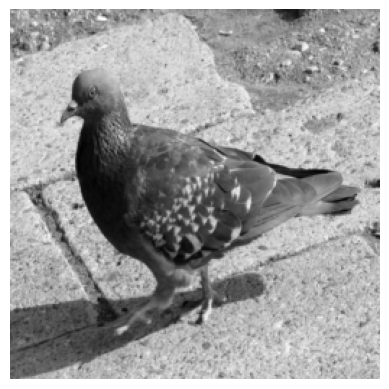

In [56]:
# Load images
folder = 'Images/'
device = 'cpu'
image = 'pigeon.jpeg'

image_path = folder + image  # Replace with your image path
image = Image.open(image_path)
transform = transforms.Compose([
        transforms.Grayscale(),  # Convert to grayscale
        transforms.Resize((256, 256)), # Resize to 256x256 to speed up processing
        transforms.ToTensor()  
    ])
img_tensor = transform(image).squeeze()  # Remove channel dimension

# Display the image
plt.imshow(img_tensor, cmap='gray')
plt.axis('off')



Degraded image size: torch.Size([256, 256])
Kernel size: torch.Size([1, 1, 21, 21])
Estimate size: torch.Size([256, 256])


(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

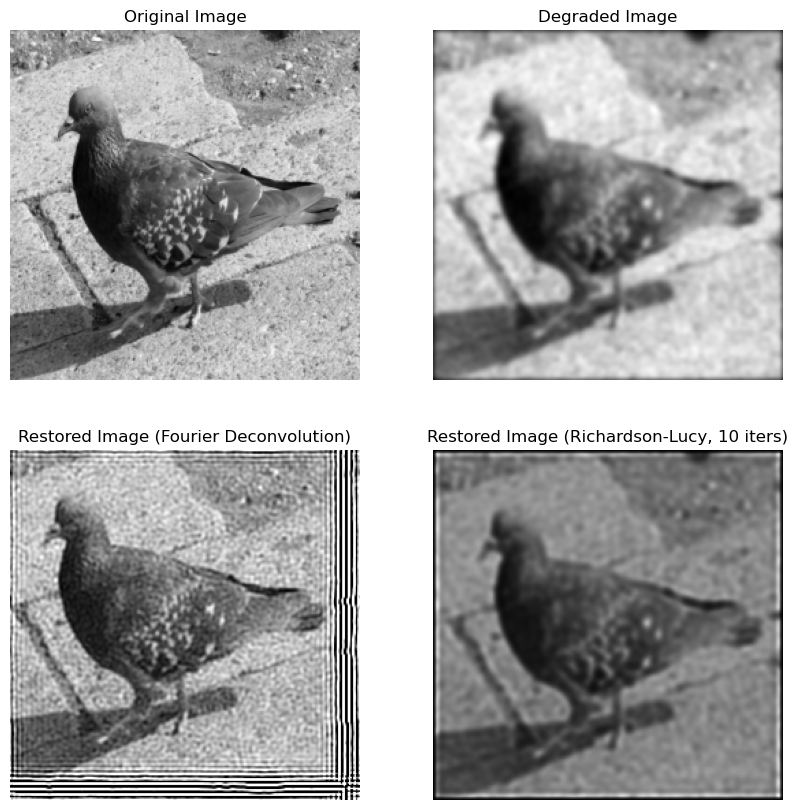

In [73]:
noisy_image = add_poisson_noise(img_tensor, scale_factor=50)
kernel = gaussian_normalised_kernel(size=21.0, sigma=2.0)
iters_rl = 10
degraded_image = convolution(noisy_image, kernel)
restored_image_ft = deconvolution(degraded_image, kernel)
restored_image_rl30 = richardson_lucy(degraded_image, kernel, num_iters=iters_rl)

# Display the results
figs, axs = plt.subplots(2, 2, figsize=(10,10))
axs[0,0].imshow(img_tensor, cmap='gray')
axs[0,0].set_title('Original Image')
axs[0,0].axis('off')
axs[0,1].imshow(degraded_image, cmap='gray')
axs[0,1].set_title('Degraded Image')
axs[0,1].axis('off')
axs[1,0].imshow(restored_image_ft, cmap='gray')
axs[1,0].set_title('Restored Image (Fourier Deconvolution)')
axs[1,0].axis('off')
axs[1,1].imshow(restored_image_rl30, cmap='gray')
axs[1,1].set_title(f'Restored Image (Richardson-Lucy, {iters_rl} iters)')
axs[1,1].axis('off')

## Discussion

- Deconvolution by fourier transform doesn't remove noise in the frequency domain this means that the overall image looks visually disturbing.
- The Richardson Lucy algorithm seems to have done a better job and the image is much sharper than using the fourier deconvolution, there is also less noise present in the image. The main downside is the reduced 

## References
[1] William Hadley Richardson, "Bayesian-Based Iterative Method of Image Restoration*," J. Opt. Soc. Am. 62, 55-59 (1972)